## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 35 columns):
DAMAGE_PROPERTY       8308 non-null float64
DURATION_SECONDS      8308 non-null float64
BEGIN_LAT             8308 non-null float64
BEGIN_LON             8308 non-null float64
TOR_LENGTH            8308 non-null float64
TOR_WIDTH             8308 non-null float64
YEAR                  8308 non-null float64
MULTI_VORT_IND        8308 non-null int64
OPEN_WATER_PROP       8308 non-null float64
DEV_OPEN_PROP         8308 non-null float64
DEV_LOW_PROP          8308 non-null float64
DEV_MED_PROP          8308 non-null float64
DEV_HIGH_PROP         8308 non-null float64
BARREN_LAND_PROP      8308 non-null float64
DECID_FOREST_PROP     8308 non-null float64
EVERGR_FOREST_PROP    8308 non-null float64
MIXED_FOREST_PROP     8308 non-null float64
SHRUB_SCRUB_PROP      8308 non-null float64
GRASS_LAND_PROP       8308 non-null float64
PASTURE_HAY_PROP      8308 non-null float64
CULT_CROPS_PROP

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [0]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 1 columns):
DAMAGE_PROPERTY    8308 non-null float64
dtypes: float64(1)
memory usage: 65.0 KB


In [4]:
# The independent variables
tornado_features = tor_df.loc[:, ["DURATION_SECONDS",
                                  "TOR_LENGTH",
                                  "TOR_WIDTH",
                                  "YEAR",
                                  "MULTI_VORT_IND",
                                  "TOR_AREA",
                                  "DAY_OF_YEAR",
                                  "MONTH",
                                  "TIME"]]


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 9 columns):
DURATION_SECONDS    8308 non-null float64
TOR_LENGTH          8308 non-null float64
TOR_WIDTH           8308 non-null float64
YEAR                8308 non-null float64
MULTI_VORT_IND      8308 non-null int64
TOR_AREA            8308 non-null float64
DAY_OF_YEAR         8308 non-null float64
MONTH               8308 non-null float64
TIME                8308 non-null float64
dtypes: float64(8), int64(1)
memory usage: 584.2 KB


In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.1532
 0.6540
 0.0873
   ⋮    
 0.5790
 0.1532
 0.2814
[torch.DoubleTensor of size 8308x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 0.0227 -0.4127 -0.7859  ...  -0.0068 -0.2947 -0.4531
-0.3046 -1.0358 -0.9368  ...  -0.1143 -0.2947  1.1092
 0.3520  0.0818 -0.9368  ...  -0.9653 -1.0297 -0.1038
          ...             ⋱             ...          
 0.5451  0.6778 -0.3589  ...  -0.7735 -1.0297 -1.5301
 0.0227 -0.4127 -0.7859  ...   0.8091  0.8078 -2.1918
 0.4583  0.9771 -0.3589  ...  -2.1091 -1.7647  0.5064
[torch.DoubleTensor of size 8308x9]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 0.0227 -0.4127 -0.7859  ...  -0.0068 -0.2947 -0.4531
-0.3046 -1.0358 -0.9368  ...  -0.1143 -0.2947  1.1092
 0.3520  0.0818 -0.9368  ...  -0.9653 -1.0297 -0.1038
          ...             ⋱             ...          
 0.5451  0.6778 -0.3589  ...  -0.7735 -1.0297 -1.5301
 0.0227 -0.4127 -0.7859  ...   0.8091  0.8078 -2.1918
 0.4583  0.9771 -0.3589  ...  -2.1091 -1.7647  0.5064
[torch.FloatTensor of size 8308x9]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

In [12]:
# Get the iterations
iterations = list(range(0, 15000))

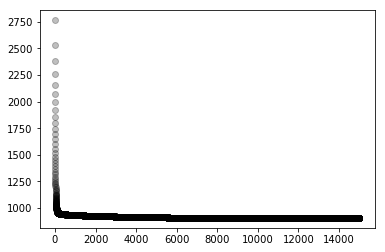

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(8308)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

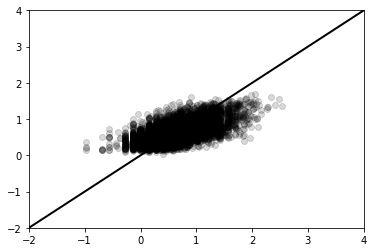

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [0]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)


# Quick check
valid_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 1 columns):
DAMAGE_PROPERTY    2808 non-null float64
dtypes: float64(1)
memory usage: 22.0 KB


In [18]:
# Validation set predictors
valid_predictors = valid_df.loc[:, ["DURATION_SECONDS",
                                    "TOR_LENGTH",
                                    "TOR_WIDTH",
                                    "YEAR",
                                    "MULTI_VORT_IND",
                                    "TOR_AREA",
                                    "DAY_OF_YEAR",
                                    "MONTH",
                                   "TIME"]]


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)


# Quick check
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 9 columns):
DURATION_SECONDS    2808 non-null float64
TOR_LENGTH          2808 non-null float64
TOR_WIDTH           2808 non-null float64
YEAR                2808 non-null float64
MULTI_VORT_IND      2808 non-null int64
TOR_AREA            2808 non-null float64
DAY_OF_YEAR         2808 non-null float64
MONTH               2808 non-null float64
TIME                2808 non-null float64
dtypes: float64(8), int64(1)
memory usage: 197.5 KB


In [19]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 304.9131
[torch.FloatTensor of size 1]

In [20]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3586
[torch.FloatTensor of size 1]

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(2808)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Convert back to log scale
valid_outcomes_array = valid_outcomes_array*5.407597 + 7.688844


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

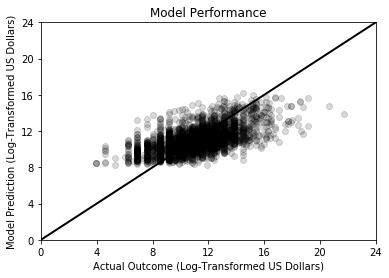

In [23]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [24]:
model[(0)].weight

Parameter containing:
-0.0902 -0.6311  0.3042  0.2518  1.0277 -0.0872 -0.0341 -0.1086  0.0316
-0.0691  0.1456  0.3461 -0.0848  0.2448  0.0400 -0.0941 -0.0381 -0.0539
 0.0367 -0.6364 -0.2506 -0.0643 -0.3427 -0.0494 -0.0659  0.1054  0.0545
 0.0353 -0.3566  0.0187  0.1144 -0.1083 -0.3320  0.0075 -0.0597  0.1464
-0.1298  0.4246 -0.0592 -0.2379  0.2100  0.1457 -0.0192  0.3644 -0.0176
 0.2389 -0.1147  0.3532  0.1844  0.2759  0.0872 -0.0094 -0.0317  0.0025
[torch.FloatTensor of size 6x9]

In [25]:
model[(2)].weight

Parameter containing:
-0.2945  0.4051 -0.6093  0.3780  0.1812  0.2673
[torch.FloatTensor of size 1x6]

## Round 2: Two-Hidden-Layer Neural Network

In [26]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [27]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 1))

In [28]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

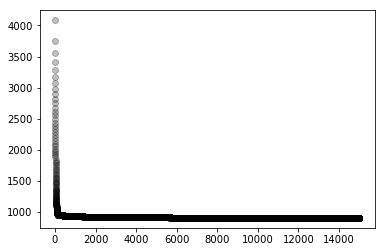

In [29]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [30]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

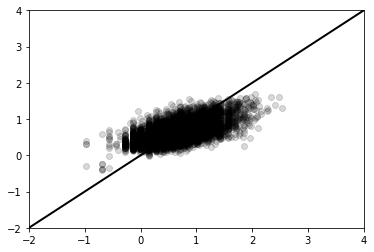

In [31]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [32]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 301.3170
[torch.FloatTensor of size 1]

In [33]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3662
[torch.FloatTensor of size 1]

In [34]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

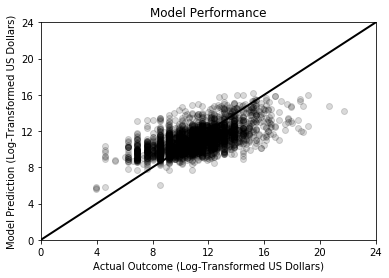

In [35]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [36]:
model[(0)].weight

Parameter containing:
-0.0851 -0.2946 -0.2650 -0.0792 -0.1680  0.0580  0.4648 -0.2918 -0.0727
 0.4001 -0.2064  0.3380  0.0252 -0.0865  0.3720 -0.1750  0.0242  0.1205
 0.3160  0.1297 -0.1194 -0.4813 -0.0159  0.0580 -0.2086  0.0946 -0.1807
 0.1176  0.3163  0.1732 -0.4877  0.0266  0.2684 -0.1331  0.2937  0.0592
-0.6321  0.9999  0.2177 -0.2313  0.0560  0.2179  0.0158 -0.0182 -0.4826
-0.2211 -0.0796 -0.4788  0.2842  0.4423  0.2832 -0.0465 -0.2451 -0.7148
[torch.FloatTensor of size 6x9]

In [37]:
model[(2)].weight

Parameter containing:
 0.4691 -0.2171 -1.0273 -0.3976  0.3006 -0.0737
-0.0555  0.5055 -0.2516  0.3169  0.4886  0.0324
-0.7626 -0.4184  0.5780 -0.3884  0.4783 -0.4238
-0.5313 -0.4159  0.3083 -0.5359 -0.3583 -0.3478
[torch.FloatTensor of size 4x6]

In [38]:
model[(4)].weight

Parameter containing:
-0.6412  0.4007 -0.4230 -0.8201
[torch.FloatTensor of size 1x4]

## Round 3: Three-Hidden-Layer Neural Network

In [39]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [40]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [41]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

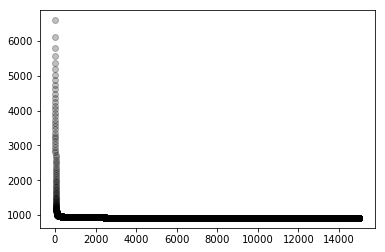

In [42]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [43]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

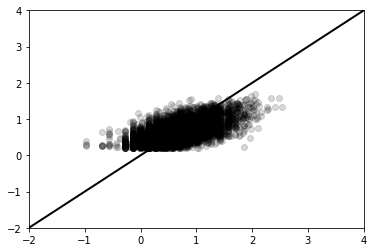

In [44]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [45]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 304.5199
[torch.FloatTensor of size 1]

In [46]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3594
[torch.FloatTensor of size 1]

In [47]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

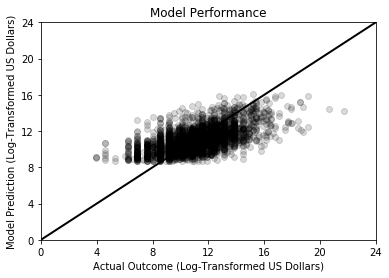

In [48]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [49]:
model[(0)].weight

Parameter containing:
 0.3657  0.3275  0.4583 -0.1525 -0.4419  0.0911 -0.1510 -0.3260  0.0796
 0.3334  0.0007  0.4507  0.0998  0.0229  0.3473  0.1257 -0.1367  0.0570
 0.2157  0.0594  0.1408 -0.0754  0.1405  0.1451  0.0051  0.2271  0.0358
-0.4565 -0.4137 -0.4641 -0.0705 -0.8952 -0.3222 -0.0770  0.2763  0.0013
-0.3376 -0.4433 -0.4512 -0.1706 -0.2397  0.6458 -0.0126  0.1790  0.2460
-0.4255  0.4847  0.3743 -0.2466  0.1322  0.0711 -0.1208  0.4573 -0.4349
[torch.FloatTensor of size 6x9]

In [50]:
model[(2)].weight

Parameter containing:
-0.0068  0.0981  0.2801 -0.2765  0.4327  0.0979
 0.3118  0.2975  0.3025 -0.1963  0.3100  0.6854
-0.2037 -0.0803  0.3080 -0.2800  0.5158 -0.0478
 0.5149  0.3937  0.1419 -0.2750 -0.0055  0.1993
[torch.FloatTensor of size 4x6]

In [51]:
model[(4)].weight

Parameter containing:
 0.3130 -0.0380  0.2527 -0.0290
 0.2707  0.1935  0.4566  0.2510
 0.3516  0.1397  0.2997  0.6572
[torch.FloatTensor of size 3x4]

In [52]:
model[(6)].weight

Parameter containing:
-0.2316  0.3802  0.2129
[torch.FloatTensor of size 1x3]

## Round 4: Four-Hidden-Layer Neural Network

In [53]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [54]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [55]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

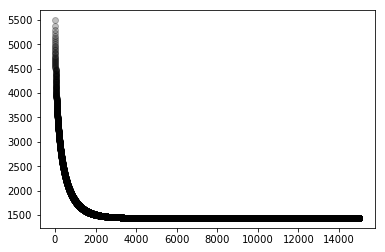

In [56]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [57]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

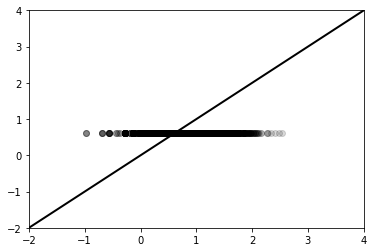

In [58]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [59]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 475.4064
[torch.FloatTensor of size 1]

In [60]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
1.00000e-05 *
 -4.9472
[torch.FloatTensor of size 1]

In [61]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

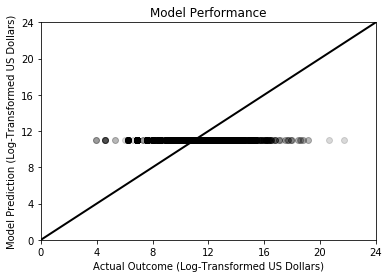

In [62]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [63]:
model[(0)].weight

Parameter containing:
 0.0710  0.0117  0.0329 -0.0105 -0.1232  0.0473 -0.2240  0.1305  0.1330
 0.0902  0.2013 -0.3213 -0.1547 -0.3046 -0.1570  0.2743 -0.0519  0.1653
 0.2068 -0.1571  0.2101  0.3098  0.0430 -0.3320  0.0558  0.1815 -0.2617
-0.1511 -0.3224 -0.1114  0.0378  0.0372  0.2115  0.0113 -0.0486  0.2372
-0.3143 -0.2587  0.1130  0.1323 -0.2293  0.0718  0.1748  0.1986  0.1029
-0.0868  0.0904 -0.0341 -0.0778 -0.1144  0.1679  0.2977  0.3231 -0.2496
[torch.FloatTensor of size 6x9]

In [64]:
model[(2)].weight

Parameter containing:
 0.1856  0.2905  0.0990 -0.1846 -0.3493 -0.1585
 0.2737 -0.0088 -0.3800  0.2225  0.1992  0.1035
-0.0427 -0.2179  0.2469 -0.2147 -0.2745 -0.2200
 0.2844 -0.0339 -0.1778  0.0851 -0.3839  0.1350
[torch.FloatTensor of size 4x6]

In [65]:
model[(4)].weight

Parameter containing:
-0.3460  0.1907 -0.2164 -0.2586
 0.2308  0.3946 -0.0113  0.0782
 0.3478 -0.0978  0.4848  0.3201
[torch.FloatTensor of size 3x4]

In [66]:
model[(6)].weight

Parameter containing:
-0.4473 -0.3986  0.2818
-0.0330  0.4348  0.3167
[torch.FloatTensor of size 2x3]

In [67]:
model[(8)].weight

Parameter containing:
-0.0839  0.3567
[torch.FloatTensor of size 1x2]

## Round 5: Linear Regression

In [68]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [69]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(9, 1))

In [70]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

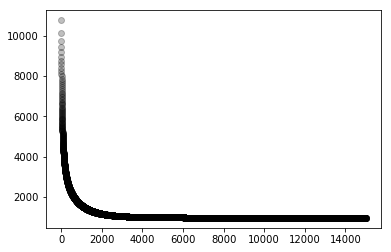

In [71]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [72]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

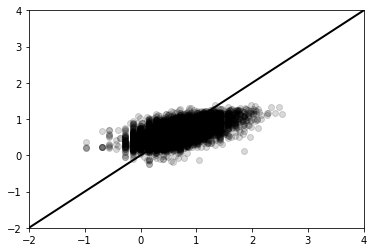

In [73]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.1: Validation Set Performance

In [74]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 313.4358
[torch.FloatTensor of size 1]

In [75]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3407
[torch.FloatTensor of size 1]

In [76]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

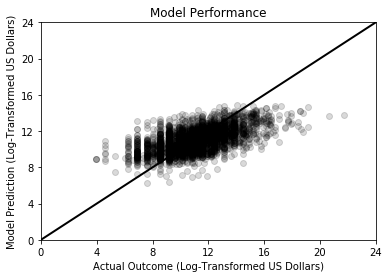

In [77]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [78]:
model[(0)].weight

Parameter containing:
 0.0047  0.1088  0.1298 -0.0293  0.0252  0.0366 -0.0320  0.0289  0.0092
[torch.FloatTensor of size 1x9]